In [11]:
import tensorflow as tf
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Setting the random seed so there is consistent data splitting between runs
tf.random.set_seed(42)
# importing the lowPPM matrix
allData = r"../Output/LowPPMMatrix.csv"

# Reading in the data to csv and removing any data at 150 ppm as this was incorrect data from testing
# NOTE: the 150 ppm is not in all outputs. but it is left in as a safeguard
df = pd.read_csv(allData)
df=df[df['Target PPM']!=150]
# Dropping all unneeded columns from the output
df = df.drop(columns=['Unnamed: 0','lowInterval','highInterval','Ratio'])
print(df.head())

# Declaring what sensor is used for the test set
test_sensor_id = 0  # Replace with the ID of the sensor you want in the test set
train_data = df[df['SensorID'] != test_sensor_id]
test_data = df[df['SensorID'] == test_sensor_id]

# Drop the SensorID column as we don't need it anymore
train_data = train_data.drop(columns=['SensorID'])
test_data = test_data.drop(columns=['SensorID'])
# Convert to TensorFlow tensors
train_data_tf = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data_tf = tf.convert_to_tensor(test_data, dtype=tf.float32)

   SensorID  Target PPM  Resistance  Temperature  RelativeHumidity
0       0.0         0.0   30.009404     0.795619          6.227832
1       3.0         0.0   28.086765     0.795619          6.227832
2       5.0         0.0   30.475486     0.795619          6.227832
3       7.0         0.0   31.911561     0.795619          6.227832
4       8.0         0.0   26.515605     0.795619          6.227832


In [13]:
# Randomizes the data for training to minimize fitting to false trends
train_data_shuffled = tf.random.shuffle(train_data_tf, seed=42)

# Separate features and labels
x_train, y_train = train_data_shuffled[:, 1:], train_data_shuffled[:, 0]
x_test, y_test = test_data_tf[:, 1:], test_data_tf[:, 0]

In [14]:
# Mean squared error function
def mse_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Root mean squared error function
def rmse(y_true, y_pred):
    return tf.sqrt(mse_loss(y_pred, y_true))

# R-Squared function to test fit of model
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

# Used to trace history of RMSE as the neural network gets trained
class RMSEHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE = []
        self.validationRMSE = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.modelRMSE.append(logs.get('rmse'))
        self.validationRMSE.append(logs.get('val_rmse'))

In [15]:
rmse_history = RMSEHistory()
# Compile and train the model
input_shape = (x_train.shape[1],)

In [ ]:
# Initialize a CSV file to store the results
csvfile = open('experiment_results.csv', 'w', newline='')
csvwriter = csv.writer(csvfile)
csvwriter.writerow(['BaseNum', 'Run', 'Test_RMSE', 'Test_Accuracy'])

for baseNum in tqdm(range(1, 16), desc='BaseNum Loop'):  # Wrap outer loop with tqdm
    for run in tqdm(range(1, 101), desc=f'Run Loop for BaseNum {baseNum}', leave=False):  # Wrap inner loop with tqdm

# Define your original model with regularization
        def build_model(input_shape, regularization_factor=0.01):
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(baseNum*2, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
                tf.keras.layers.Dense(baseNum*4, activation='mish', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(baseNum*2, activation='linear', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
                tf.keras.layers.Dense(1)
            ])
            return model

        with tf.device('/GPU:0'):
            model = build_model(input_shape)
            model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
            model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_split=0.2, callbacks=[rmse_history],verbose=0)
            test_metrics = model.evaluate(x_test, y_test,verbose=0)
            test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
        # Save the results
        csvwriter.writerow([baseNum, run, test_rmse, test_accuracy])
        csvfile.flush()
csvfile.close()

In [ ]:
df1 = pd.read_csv("./experiment_results.csv")

# Create a figure and axis object for the boxplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Create a boxplot for Test_RMSE grouped by BaseNum
df1.boxplot(column='Test_RMSE', by='BaseNum', ax=ax[0])
ax[0].set_title('Boxplot of Test_RMSE Grouped by BaseNum')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Test_RMSE')

# Create a boxplot for Test_Accuracy grouped by BaseNum
df1.boxplot(column='Test_Accuracy', by='BaseNum', ax=ax[1])
ax[1].set_title('Boxplot of Test_Accuracy Grouped by BaseNum')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Test_Accuracy')

# Show the plots
plt.suptitle('Boxplots Grouped by BaseNum')
plt.show()

# Group by BaseNum and calculate the mean
grouped_means = df1.groupby('BaseNum').mean()

# Create a figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the mean of Test_RMSE
ax[0].plot(grouped_means.index, grouped_means['Test_RMSE'], label='Test_RMSE', marker='o')
ax[0].set_xlabel('BaseNum')
ax[0].set_ylabel('Mean of Test_RMSE')
ax[0].set_title('Mean of Test_RMSE Grouped by BaseNum')
ax[0].legend()

# Plot the mean of Test_Accuracy
ax[1].plot(grouped_means.index, grouped_means['Test_Accuracy'], label='Test_Accuracy', marker='x')
ax[1].set_xlabel('BaseNum')
ax[1].set_ylabel('Mean of Test_Accuracy')
ax[1].set_title('Mean of Test_Accuracy Grouped by BaseNum')
ax[1].legend()

# Show the plot
plt.show()

In [22]:
import random
from keras.src.losses import mean_squared_error

activation_functions = ['relu', 'sigmoid', 'elu', 'selu', 'swish', 'linear', 'softmax', 'softplus']

best_activation = None
lowest_mse = float('inf')
baseNum = 4
n=100
for _ in tqdm(range(n), desc='BaseNum Loop'):
    # Randomly select activation functions for each layer
    activation = [random.choice(activation_functions) for _ in range(4)]
    rmse_list = []
    def build_model(input_shape, regularization_factor=0.01):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(baseNum*2, activation=activation[0], kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
            tf.keras.layers.Dense(baseNum*4, activation=activation[1], kernel_regularizer=regularizers.l2(regularization_factor)),
            tf.keras.layers.Dense(baseNum*4, activation=activation[2], kernel_regularizer=regularizers.l2(regularization_factor)),
            tf.keras.layers.Dense(baseNum*2, activation=activation[3], kernel_regularizer=regularizers.l2(regularization_factor)),
            tf.keras.layers.Dense(1)
        ])
        return model
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    for _ in range(int(n/2)):
        # Create and train the model
        with tf.device('/GPU:0'):
    #regular model training
            model = build_model(input_shape)
            model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
            model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.2, callbacks=[early_stopping,rmse_history],verbose=0)

        # Evaluate on validation data
            y_val_pred = model.predict(x_test,verbose=0)
            rmse1 = rmse(y_test, y_val_pred)
            rmse_list.append(rmse1)

    # Average RMSE for this sequence of activations
    avg_rmse = np.mean(rmse_list)
    print(f"Average RMSE with activations {activation}: {avg_rmse}")

    # Update the best activation function if needed
    if avg_rmse < lowest_mse:
        best_activation = activation
        lowest_mse = avg_rmse

print(f"Best activation function is {best_activation} with RMSE {lowest_mse}")

BaseNum Loop:   1%|          | 1/100 [04:14<7:00:35, 254.90s/it]

Average RMSE with activations ['linear', 'sigmoid', 'elu', 'sigmoid']: 19.842525482177734


BaseNum Loop:   2%|▏         | 2/100 [08:54<7:19:36, 269.15s/it]

Average RMSE with activations ['softmax', 'sigmoid', 'softmax', 'softmax']: 18.358016967773438


BaseNum Loop:   3%|▎         | 3/100 [13:07<7:03:33, 261.99s/it]

Average RMSE with activations ['selu', 'elu', 'linear', 'linear']: 23.640932083129883


BaseNum Loop:   4%|▍         | 4/100 [16:53<6:36:13, 247.64s/it]

Average RMSE with activations ['softplus', 'softplus', 'softplus', 'sigmoid']: 17.483789443969727


BaseNum Loop:   5%|▌         | 5/100 [18:29<5:05:58, 193.24s/it]

Average RMSE with activations ['softplus', 'selu', 'softmax', 'softplus']: 17.613636016845703


BaseNum Loop:   6%|▌         | 6/100 [20:23<4:20:08, 166.05s/it]

Average RMSE with activations ['swish', 'softmax', 'relu', 'selu']: 18.46160125732422


BaseNum Loop:   7%|▋         | 7/100 [25:04<5:15:44, 203.70s/it]

Average RMSE with activations ['relu', 'softmax', 'softplus', 'softmax']: 18.485633850097656


BaseNum Loop:   8%|▊         | 8/100 [29:04<5:29:59, 215.21s/it]

Average RMSE with activations ['relu', 'selu', 'elu', 'swish']: 23.47168731689453


BaseNum Loop:   9%|▉         | 9/100 [33:00<5:36:15, 221.71s/it]

Average RMSE with activations ['selu', 'selu', 'linear', 'elu']: 23.4840145111084


BaseNum Loop:  10%|█         | 10/100 [37:03<5:42:28, 228.32s/it]

Average RMSE with activations ['sigmoid', 'elu', 'relu', 'relu']: 22.918092727661133


BaseNum Loop:  11%|█         | 11/100 [38:47<4:42:10, 190.23s/it]

Average RMSE with activations ['selu', 'elu', 'softmax', 'softplus']: 17.793851852416992


BaseNum Loop:  12%|█▏        | 12/100 [43:05<5:09:33, 211.06s/it]

Average RMSE with activations ['elu', 'elu', 'linear', 'linear']: 23.582796096801758


BaseNum Loop:  13%|█▎        | 13/100 [47:12<5:21:49, 221.95s/it]

Average RMSE with activations ['sigmoid', 'relu', 'elu', 'softplus']: 23.2130069732666


BaseNum Loop:  14%|█▍        | 14/100 [51:25<5:31:30, 231.28s/it]

Average RMSE with activations ['sigmoid', 'swish', 'relu', 'sigmoid']: 19.396549224853516


BaseNum Loop:  15%|█▌        | 15/100 [54:25<5:05:27, 215.62s/it]

Average RMSE with activations ['sigmoid', 'elu', 'softmax', 'linear']: 21.038747787475586


BaseNum Loop:  16%|█▌        | 16/100 [57:12<4:41:23, 201.00s/it]

Average RMSE with activations ['softplus', 'selu', 'softmax', 'sigmoid']: 17.752185821533203


BaseNum Loop:  17%|█▋        | 17/100 [1:00:58<4:48:29, 208.55s/it]

Average RMSE with activations ['softplus', 'linear', 'sigmoid', 'elu']: 22.421175003051758


BaseNum Loop:  18%|█▊        | 18/100 [1:04:51<4:55:18, 216.08s/it]

Average RMSE with activations ['linear', 'selu', 'sigmoid', 'elu']: 23.104106903076172


BaseNum Loop:  19%|█▉        | 19/100 [1:09:06<5:07:15, 227.60s/it]

Average RMSE with activations ['sigmoid', 'softmax', 'selu', 'selu']: 23.21196746826172


BaseNum Loop:  20%|██        | 20/100 [1:13:45<5:24:14, 243.19s/it]

Average RMSE with activations ['swish', 'sigmoid', 'swish', 'softmax']: 18.520397186279297


BaseNum Loop:  21%|██        | 21/100 [1:15:22<4:22:27, 199.34s/it]

Average RMSE with activations ['elu', 'softmax', 'softmax', 'elu']: 17.526369094848633


BaseNum Loop:  22%|██▏       | 22/100 [1:20:01<4:50:08, 223.19s/it]

Average RMSE with activations ['softmax', 'selu', 'softplus', 'softmax']: 18.604572296142578


BaseNum Loop:  23%|██▎       | 23/100 [1:21:18<3:50:05, 179.29s/it]

Average RMSE with activations ['relu', 'softplus', 'softmax', 'linear']: 17.515323638916016


BaseNum Loop:  24%|██▍       | 24/100 [1:25:19<4:10:28, 197.74s/it]

Average RMSE with activations ['sigmoid', 'linear', 'linear', 'softplus']: 23.016016006469727


BaseNum Loop:  25%|██▌       | 25/100 [1:29:17<4:22:14, 209.79s/it]

Average RMSE with activations ['sigmoid', 'softplus', 'relu', 'relu']: 22.657087326049805


2023-09-18 15:26:05.134854: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at resource_variable_ops.cc:597 : INVALID_ARGUMENT: Cannot update variable with shape [] using a Tensor with shape [0], shapes must be equal.
BaseNum Loop:  25%|██▌       | 25/100 [1:30:15<4:30:47, 216.64s/it]


InvalidArgumentError: Graph execution error:

Detected at node 'AssignAddVariableOp_2' defined at (most recent call last):
    File "/Users/benfunk/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/benfunk/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/benfunk/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/benfunk/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/benfunk/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_1849/3026886570.py", line 30, in <module>
      model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.2, callbacks=[early_stopping,rmse_history],verbose=0)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1853, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 728, in update_state
      return super().update_state(matches, sample_weight=sample_weight)
    File "/Users/benfunk/anaconda3/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 528, in update_state
      update_total_op = self.total.assign_add(value_sum)
Node: 'AssignAddVariableOp_2'
Cannot update variable with shape [] using a Tensor with shape [0], shapes must be equal.
	 [[{{node AssignAddVariableOp_2}}]] [Op:__inference_test_function_71829773]

Epoch 1/500
11/11 [==============================] - 0s 7ms/step - loss: 489.3693 - r_squared: -0.5846 - rmse: 21.9541 - val_loss: 342.7349 - val_r_squared: -0.3201 - val_rmse: 18.3694
Epoch 2/500
11/11 [==============================] - 0s 1ms/step - loss: 417.7692 - r_squared: -0.3302 - rmse: 20.2818 - val_loss: 310.1700 - val_r_squared: -0.1933 - val_rmse: 17.4620
Epoch 3/500
11/11 [==============================] - 0s 1ms/step - loss: 386.3280 - r_squared: -0.2484 - rmse: 19.5187 - val_loss: 310.2894 - val_r_squared: -0.1965 - val_rmse: 17.4852
Epoch 4/500
11/11 [==============================] - 0s 1ms/step - loss: 373.7038 - r_squared: -0.2436 - rmse: 19.3284 - val_loss: 305.5872 - val_r_squared: -0.1798 - val_rmse: 17.3654
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 364.6555 - r_squared: -0.1744 - rmse: 19.0679 - val_loss: 302.8634 - val_r_squared: -0.1705 - val_rmse: 17.2997
Epoch 6/500
11/11 [==============================] - 0s 1ms/step - loss: 35

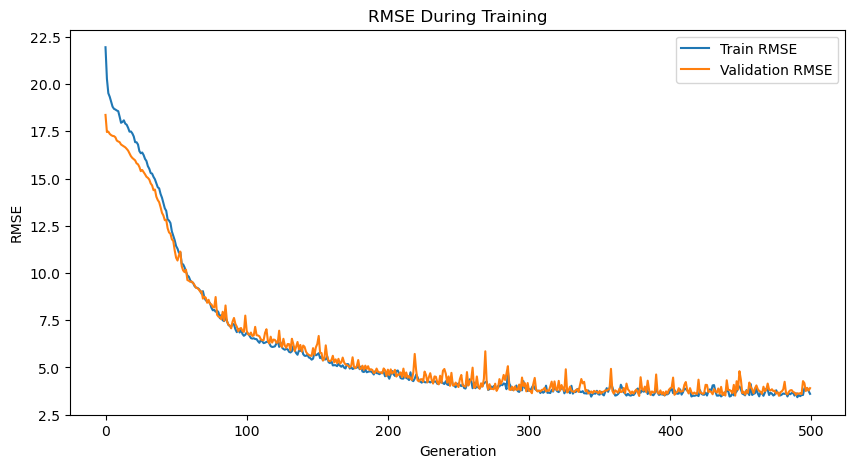

Epoch 1/200
11/11 [==============================] - 1s 8ms/step - loss: 15.5012 - r_squared: 0.9503 - rmse: 3.8329 - val_loss: 19.5900 - val_r_squared: 0.9279 - val_rmse: 4.2847
Epoch 2/200
11/11 [==============================] - 0s 2ms/step - loss: 16.9706 - r_squared: 0.9483 - rmse: 3.9540 - val_loss: 15.1959 - val_r_squared: 0.9460 - val_rmse: 3.7169
Epoch 3/200
11/11 [==============================] - 0s 2ms/step - loss: 13.3439 - r_squared: 0.9574 - rmse: 3.4886 - val_loss: 13.5750 - val_r_squared: 0.9527 - val_rmse: 3.4766
Epoch 4/200
11/11 [==============================] - 0s 2ms/step - loss: 13.2650 - r_squared: 0.9572 - rmse: 3.5352 - val_loss: 15.0925 - val_r_squared: 0.9462 - val_rmse: 3.7082
Epoch 5/200
11/11 [==============================] - 0s 2ms/step - loss: 14.5512 - r_squared: 0.9550 - rmse: 3.7183 - val_loss: 15.7704 - val_r_squared: 0.9448 - val_rmse: 3.7532
Epoch 6/200
11/11 [==============================] - 0s 2ms/step - loss: 18.6885 - r_squared: 0.9419 - rm

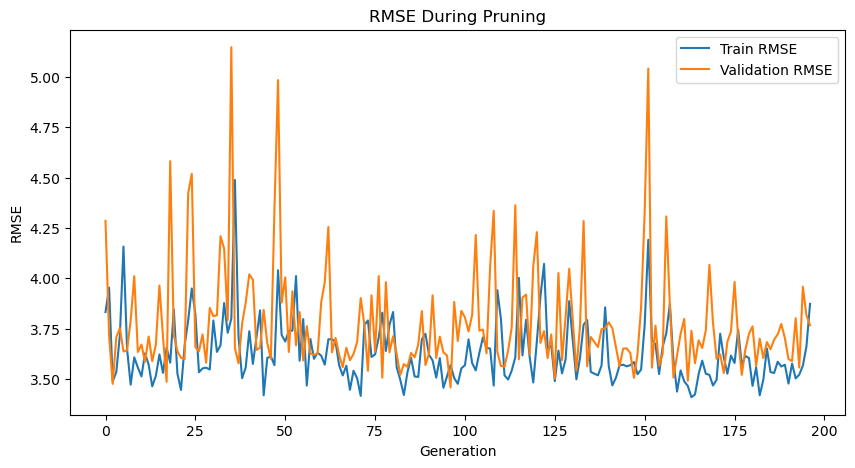

In [6]:
# NOTE: with =2 (Or any small int) it is hit or miss whether the model will go down the best optimized path. rerun a few times to determine what the best value is
#Used to quickly change size of neural net
baseNum = 4

# Define your original model with regularization
def build_model(input_shape, regularization_factor=0.01):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(baseNum*2, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor), input_shape=input_shape),
        tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*4, activation='elu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(baseNum*2, activation='linear', kernel_regularizer=regularizers.l2(regularization_factor)),
        # tf.keras.layers.Dense(baseNum, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

with tf.device('/GPU:0'):
    #regular model training
    model = build_model(input_shape)
    model.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])
    model.fit(x_train, y_train, epochs=500, batch_size=50, validation_split=0.2, callbacks=[early_stopping,rmse_history])
    # if no improvement has been made in 100 generations (epochs) stop the model
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
        print(f"Restoring model weights from the end of the best epoch.")
    else:
        print("Early stopping did not occur.")

    test_metrics = model.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")
    # Plotting RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(rmse_history.modelRMSE, label='Train RMSE')
    plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
    plt.xlabel('Generation')
    plt.ylabel('RMSE')
    plt.title('RMSE During Training')
    plt.legend()
    plt.show()

    # Pruning model. use the final_sparsity to trim the model. 0.5 means 50% of the nodes get trimmed, 0.9 means 90% of the nodes get trimmed. typically 0.6 is a good starting point for this when using large models
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
                                                    final_sparsity=0.0,
                                                    begin_step=len(x_train) // 50 * 10,
                                                    end_step=len(x_train) // 50 * 500)
    }

    model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)
    model_for_pruning.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared,rmse])

    callbacks = [
        sparsity.UpdatePruningStep(),
        early_stopping,
        rmse_history
    ]

    model_for_pruning.fit(x_train, y_train, epochs=200, batch_size=50, validation_split=0.2, callbacks=callbacks)

    # Remove the pruning wrappers to finalize the model
    modelFinal = sparsity.strip_pruning(model_for_pruning)
    modelFinal.compile(optimizer='adam', loss=mse_loss, metrics=[r_squared, rmse])

if early_stopping.stopped_epoch > 0:
    print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch}")
    print(f"Restoring model weights from the end of the best epoch.")
else:
    print("Early stopping did not occur.")

# Make predictions
with tf.device('/GPU:0'):  # This line is optional
    test_metrics = modelFinal.evaluate(x_test, y_test)
    test_loss, test_accuracy, test_rmse = test_metrics[0], test_metrics[1], test_metrics[2]
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test Accuracy: {test_accuracy*100}")
    print(f"Test RMSE: {test_rmse}")


# Plotting RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_history.modelRMSE, label='Train RMSE')
plt.plot(rmse_history.validationRMSE, label='Validation RMSE')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.title('RMSE During Pruning')
plt.legend()
plt.show()
# model.save('MethaneModel.keras')

In [ ]:
# Used to save the model
#modelFinal.save('MethaneModelBest362-947-4nodes.keras')

3/3 [==============================] - 0s 733us/step


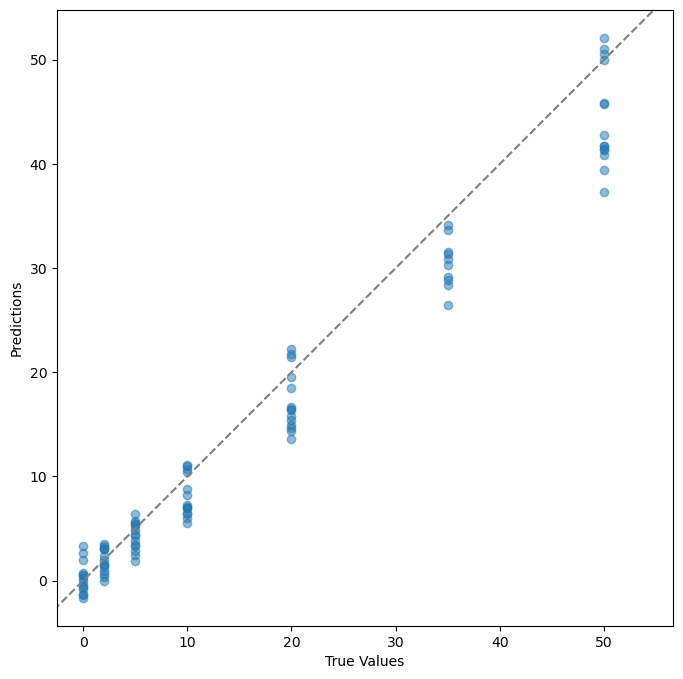

In [7]:
import matplotlib.pyplot as plt

# Generate predictions on the test data
with tf.device('/GPU:0'):  # Optional
    y_pred = model.predict(x_test)

# Flatten y_test and y_pred for plotting
y_test_flat = y_test.numpy().flatten()
y_pred_flat = y_pred.flatten()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')

# Plot a 45-degree line for reference
plt.plot([-100, 1200], [-100, 1200], '--', color='gray')

plt.show()


In [8]:
print(df.columns)

Index(['SensorID', 'Target PPM', 'Resistance', 'Temperature',
       'RelativeHumidity'],
      dtype='object')


31250/31250 [==============================] - 7s 210us/step


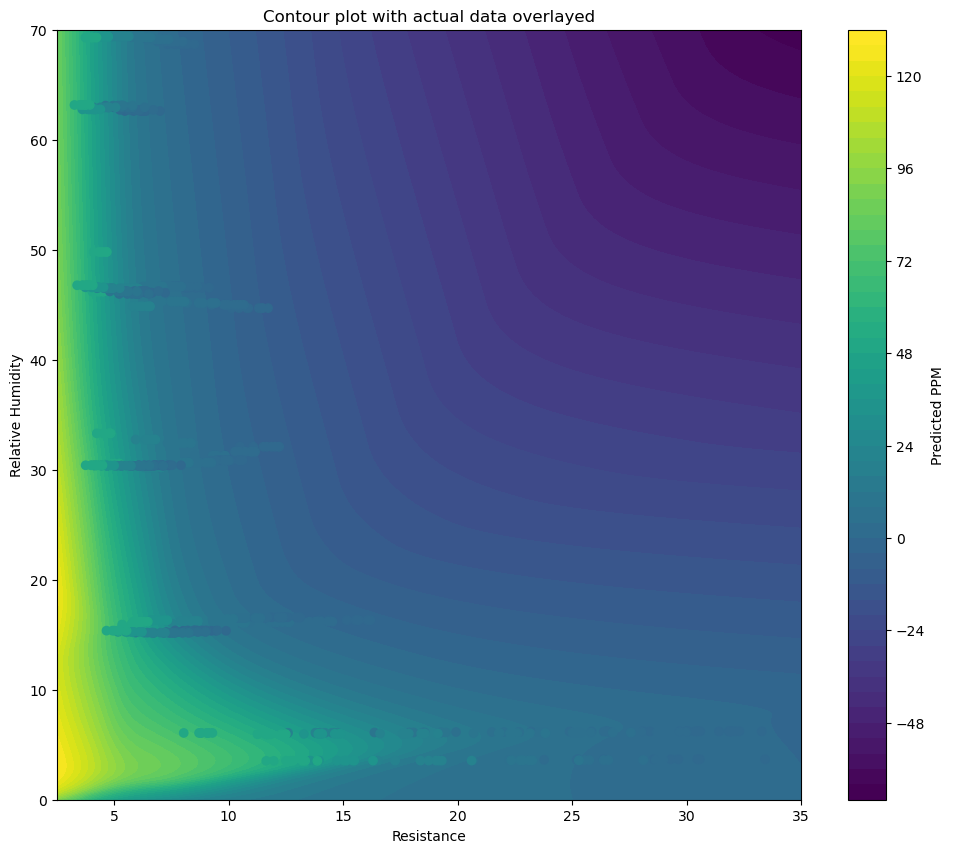

In [9]:
# Generate a grid for contour plotting
resistance_range = np.linspace(2.5, 35, 1000)
rh_range = np.linspace(0, 70, 1000)
temp = 20

# Create a grid (meshgrid) of Resistance and Relative Humidity values
resistance_values, rh_values = np.meshgrid(resistance_range, rh_range)

# Flatten the 2D arrays to 1D arrays
flat_resistance = resistance_values.ravel()
flat_rh = rh_values.ravel()

# Create a constant array filled with the temperature value
flat_temp = np.full_like(flat_resistance, temp)

# Prepare the grid data for prediction
grid_data = np.column_stack((flat_resistance, flat_temp, flat_rh))
grid_data_tf = tf.convert_to_tensor(grid_data, dtype=tf.float32)

# Use the trained model to make predictions on the grid
with tf.device('/GPU:0'):
    pred_ppm = model.predict(grid_data_tf)

# Reshape the predicted data to match the grid shape
pred_ppm = pred_ppm.reshape(resistance_values.shape)

# Create contour plot
plt.figure(figsize=(12, 10))

# Defining color range limits
vmin_val = min(pred_ppm.min(), df['Target PPM'].min())
vmax_val = max(pred_ppm.max(), df['Target PPM'].max())

contour = plt.contourf(resistance_range, rh_range, pred_ppm, 50, cmap='viridis', vmin=vmin_val, vmax=vmax_val)
plt.colorbar(label='Predicted PPM')

# Overlay actual data points
plt.scatter(df['Resistance'], df['RelativeHumidity'], c=df['Target PPM'], cmap='viridis', vmin=vmin_val, vmax=vmax_val)

# Labels and title
plt.xlabel('Resistance')
plt.ylabel('Relative Humidity')
plt.title('Contour plot with actual data overlayed')

plt.show()
